In [12]:
import numpy as np
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import time
import multiprocessing
import os
from copy import deepcopy
import numpy.ma as ma

In [31]:
%run ../methodsMemoryDeposition

In [32]:
def main(params):
    np.random.seed() 
    width = params["dom"]
    d = params["ndim"]
    params["max_CDF"] = max_CDF(params)
    t = n_ptcls = n_snapshot = 0 

    max_height_time = []
    times = []

    shape = tuple(width for _ in range(d))
    max_height_flat = np.zeros((np.power(width, d)), dtype=int) #occupation/height at each site
    t_next = np.array([single_time(0, params) for _ in range(np.power(width, d))])

    while(t < params["t_max"]):
        try:
            index_chosen = np.argmin(t_next)
            t_min = t_next[index_chosen]
            max_height_flat = add_point_ndarray(index_chosen, max_height_flat, shape)
            
            if t_min == np.inf:
                print(f"EVERYONE IS DEAD AT: {t} | N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
                break
            
            neighbors = get_nearest_non_diagonal_neighbors(index_chosen, shape)
            for index_ngbh in neighbors:
                t_next[index_ngbh] = single_time(t_min, params)
            t_next[index_chosen] = single_time(t_min, params)

            t = t_min

            if (
                t > n_snapshot*params["dt_snapshot"]
                ) or (
                    n_ptcls%params["n_ptcl_snapshot"] == 0
                    ):
                max_height_time.append(deepcopy(max_height_flat))
                times.append(t)

                n_snapshot += 1
            n_ptcls += 1

        except KeyboardInterrupt:
            print(f"Manually Stopped at time: {t}| N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
            break
    else:
        print(f"Stopped at time: {t}| N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
    return max_height_time, times

In [15]:
params = {
    "height":              1000,
    "dom":                 1000,
    "ndim":                   1,
    "t_max":               1000,
    "r_0":                    2,
    "tau":                   1,
    "dt_snapshot":            1,       
    "n_ptcl_snapshot":    np.inf,
    "foldername":  "SimResults",
}

In [209]:
r = params["r_0"]
tau = params["tau"]
params["filename"] = f"result_r0_{r:.1e}&tau_{tau:.1e}"
_ = main1D_w_plotting(params)

Fully Occupied at time: 266.592710362693| N_Ptcls: 429031| N_snapshots: 267


In [6]:
max_height_time, times = main(params)

EVERYONE IS DEAD AT: 1662.313591108558 | N_Ptcls: 136131| N_snapshots: 167


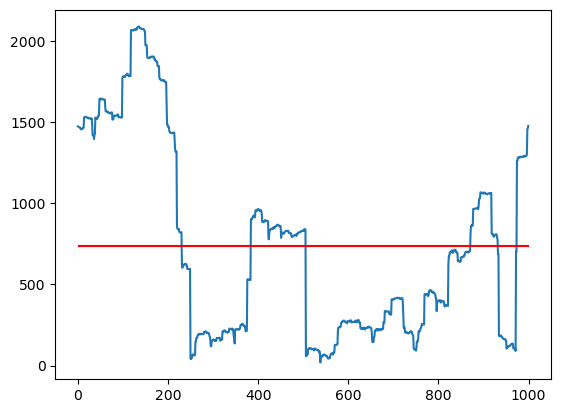

In [18]:
plt.figure()
plt.plot(max_height_time[-1])
plt.hlines(np.mean(max_height_time[-1]), 0, 1000, colors='r')
plt.show()

In [5]:
height = max_height_time[-1]
above_normal = (height >= np.mean(height))

In [16]:
def get_fingers(max_height):
    height = max_height
    above_normal = (height >= np.mean(height))
    
    means = []
    sizes = []
    current_size = 0
    current_mean = 0
    current_location = 0

    for site in above_normal:

        if site:
            current_size += 1
            current_mean += current_location
        
        if not site:
            if current_size != 0:
                sizes.append(current_size)
                means.append(current_mean)
            current_size = 0
            current_mean = 0
        
        current_location += 1

    else:
        if current_size != 0:
            if above_normal[0] == above_normal[-1]:
                means[0] += current_size*params["dom"] - current_mean
                sizes[0] += current_size
            else:
                sizes.append(current_size)
                means.append(current_mean)

    means = np.array(means)/np.array(sizes)
    return means, sizes



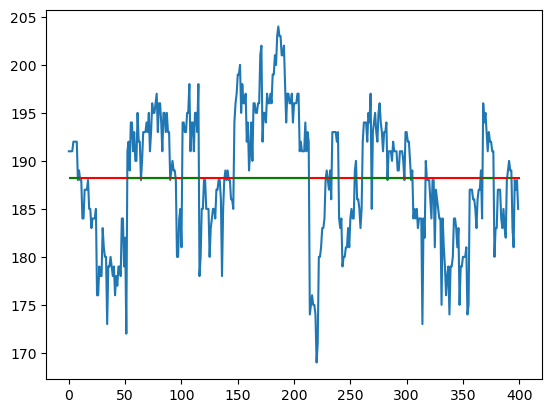

In [8]:
plt.figure()
plt.plot(max_height_time[-1])

mean_line = np.mean(max_height_time[-1])
means, sizes = get_fingers(max_height_time[-1])

plt.hlines(mean_line, 0, params["dom"], colors='r')

for size, mean in zip(sizes, means):
    low_bound = mean-size/2
    high_bound = mean+size/2

    if low_bound <= 0:
        plt.hlines(mean_line, params["dom"]-low_bound, params["dom"], colors="g")
        low_bound = 0
    plt.hlines(mean_line, low_bound, high_bound, colors='g')
plt.show()

In [35]:
params = {
    "height":             10000,
    "dom":                  500,
    "ndim":                   1,
    "t_max":               1000,
    "r_0":                    1,
    "tau":                    1,
    "dt_snapshot":            1,       
    "n_ptcl_snapshot":    np.inf,
    "foldername":  "SimResults",
    "filename": "shit",
}

In [17]:
def main_Finger(params):
    width = params["dom"]
    d = 1
    params["max_CDF"] = cutoff = max_CDF(params)
    t = n_ptcls = n_snapshot = 0 
    max_height_time = []
    finger_means = []
    finger_sizes = []
    times = []

    shape = tuple(width for _ in range(d))
    max_height = np.zeros((width), dtype=int) #occupation/height at each site
    t_next = np.array([single_time(0, params) for _ in range(width)])

    while(t<params["t_max"]):
        index_chosen = np.argmin(t_next)
        t_min = t_next[index_chosen]

        if t_min == np.inf:
            print(f"EVERYONE IS DEAD AT: {t} | N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")

        max_height = add_point_ndarray(index_chosen, max_height, shape)

        neighbors = get_nearest_non_diagonal_neighbors(index_chosen, shape)
        for index_ngbh in neighbors:
            t_next[index_ngbh] = single_time(t_min, params)
        t_next[index_chosen] = single_time(t_min, params)

        t = t_min

        if (
            t > n_snapshot*params["dt_snapshot"]
            ) or (
                n_ptcls%params["n_ptcl_snapshot"] == 0
                ):
                max_height_time.append(max_height)
                means, sizes = get_fingers(max_height)
                finger_means.append(means)
                finger_sizes.append(sizes)
                times.append(t)

                n_snapshot += 1
        n_ptcls += 1

    mean_sizes_time = [np.mean(sizes) for sizes in finger_sizes]
    std_sizes_time = [np.std(sizes) for sizes in finger_sizes]
    mean_num_time = [len(sizes) for sizes in finger_sizes]
    y_low = np.array(mean_sizes_time) - np.array(std_sizes_time)
    y_high = np.array(mean_sizes_time) + np.array(std_sizes_time)

    return times, mean_sizes_time, (y_low, y_high), mean_num_time

In [ ]:
num_repeats = 5

for r0 in [0.94,1, 1.04]:
    params["r0"] = r0
    for _ in range(num_repeats):
        times, mean_sizes_time, low_high, mean_num_time = main_Finger(params)
        y_low, y_high = low_high

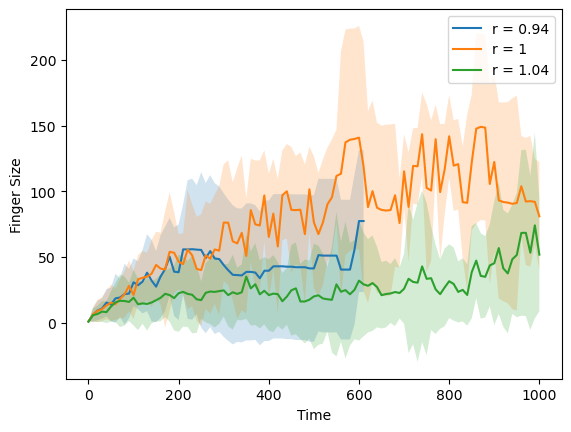

In [203]:

plt.plot(times0, mean_sizes_time0, label=label0)
plt.fill_between(times0, y_low0, y_high0, alpha=0.2)

plt.plot(times1, mean_sizes_time1, label=label1)
plt.fill_between(times1, y_low1, y_high1, alpha=0.2)

plt.plot(times2, mean_sizes_time2, label=label2)
plt.fill_between(times2, y_low2, y_high2, alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Finger Size")
plt.legend()

0.94
1
1.04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


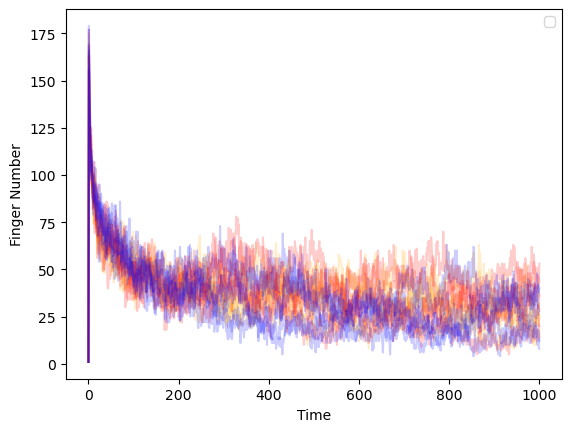

In [19]:
num_repeats = 5

for r0, color in zip([0.94,1, 1.04], ["orange","red", "blue"]):
    params["r0"] = r0
    print(r0)
    
    for _ in range(num_repeats):
        times, mean_sizes_time, low_high, mean_num_time = main_Finger(params)
        y_low, y_high = low_high
        plt.plot(times, mean_num_time, color = color, alpha = 0.2)

plt.xlabel("Time")
plt.ylabel("Finger Number")
plt.legend()

In [77]:
import multiprocessing
from joblib import delayed, Parallel, parallel_backend
num_threads = 4
max_heights_mean = []
max_heights_std = []
params["dom"] = 500
params["t_max"] = 10000

def sweep_max_height(params):
    for i in np.arange(-1, 0.2, 0.1):
        params["tau"] = 10**i
        
        data_list = [deepcopy(params) for _ in range(num_threads)]
        results = Parallel(n_jobs=num_threads)(delayed(main)(params) for params in data_list)

        error = []
        mean = []
        for i in results:
            max_height_time, _ = i
            mean.append(np.mean(max_height_time[-1]))
        
        max_heights_mean.append(mean/num_threads)
        max_heights_std.append(np.var(mean))
    return max_heights_mean, max_heights_std

In [ ]:
max_heights_mean, max_heights_std = sweep_max_height(params)

In [ ]:
taus = 10**np.arange(-1, 0.2, 0.1)
f = lambda x: np.divide((1-np.exp(-1*x)), (np.exp(-1*x)))
i = 0
plt.plot(taus, f(taus), label='Jakob')

for dom in [100, 500, 1000]:
    params["dom"] = dom
    max_heights_mean, max_heights_std = sweep_max_height(params)
    y_low = np.array(max_heights_mean) - np.array(max_heights_std)
    y_high = np.array(max_heights_mean) + np.array(max_heights_std)
    plt.plot(taus, max_heights_mean, label=f'Data L = {dom}')
    plt.fill_between(taus, y_low, y_high, alpha=0.2)
    i+=1
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\tau$ [1/s]")
plt.ylabel("Height at Death [1]")
plt.legend()

In [80]:
len(max_heights_mean)

23

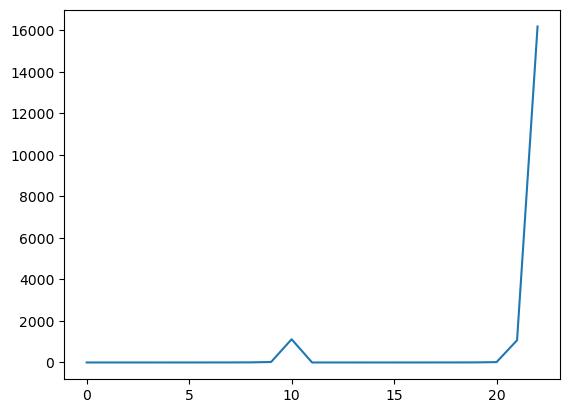

In [81]:
plt.plot(max_heights_mean)